In [28]:
import sys
sys.path.append('/home/seabra/fingerprint-enhancement/')
sys.path.append('/home/seabra/fingerprint-enhancement/src')


from models.enhancer_module import *
from models.components.ResUNet import *
from data.enhancer_train_datamodule import EnhancerTrainDataModule

In [29]:
batch_size  = 2
data_dir   = '/storage/seabra/basen_train/'
data_module = EnhancerTrainDataModule(data_dir=data_dir, lat_subdir='occlusions/synth_lats/', occ_mask_subdir='/occlusions/occ_masks/', ref_subdir='/ref_NFIQ80/', bin_subdir='/ref_bin/', mnt_subdir='/mnts_ref_fusion/', skel_subdir='/ref_skel/', mask_subdir='masks_orig/',  data_list='occlusions/lat_list.txt', batch_size=batch_size)

data_module.setup()
x, labels = next(iter(data_module.train_dataloader()))


In [30]:
labels[0].shape

torch.Size([4, 512, 512])

In [31]:
x.shape

torch.Size([2, 1, 512, 512])

## visualize orig, skel, mask and mnt_map labels

In [32]:
orig, bin, mask, occ_mask = labels[:,0,:,:],  labels[:,1,:,:],  labels[:,2,:,:], labels[:,3,:,:]

Text(0.5, 1.0, 'Mask')

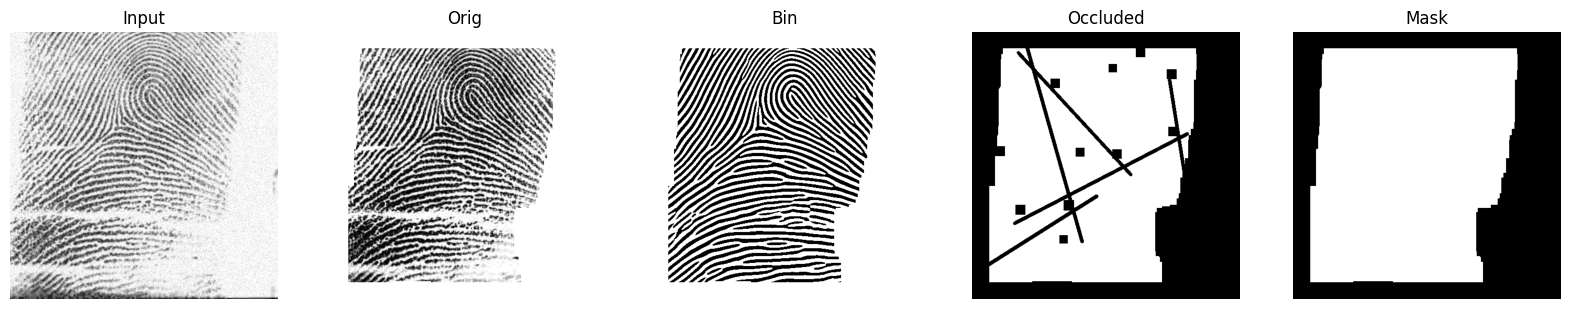

In [33]:

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize = (20,15), nrows=1, ncols = 5)
ax[0].imshow(x[0][0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Input')

ax[1].imshow(orig[0], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Orig')

ax[2].imshow(bin[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('Bin')

ax[3].imshow(mask[0]*occ_mask[0], cmap = 'gray')
ax[3].axis('off')
ax[3].set_title('Occluded')

ax[4].imshow(mask[0], cmap = 'gray')
ax[4].axis('off')
ax[4].set_title('Mask')

## Visualize Occluded Loss

Text(0.5, 1.0, 'Target Data (Ground Truth)')

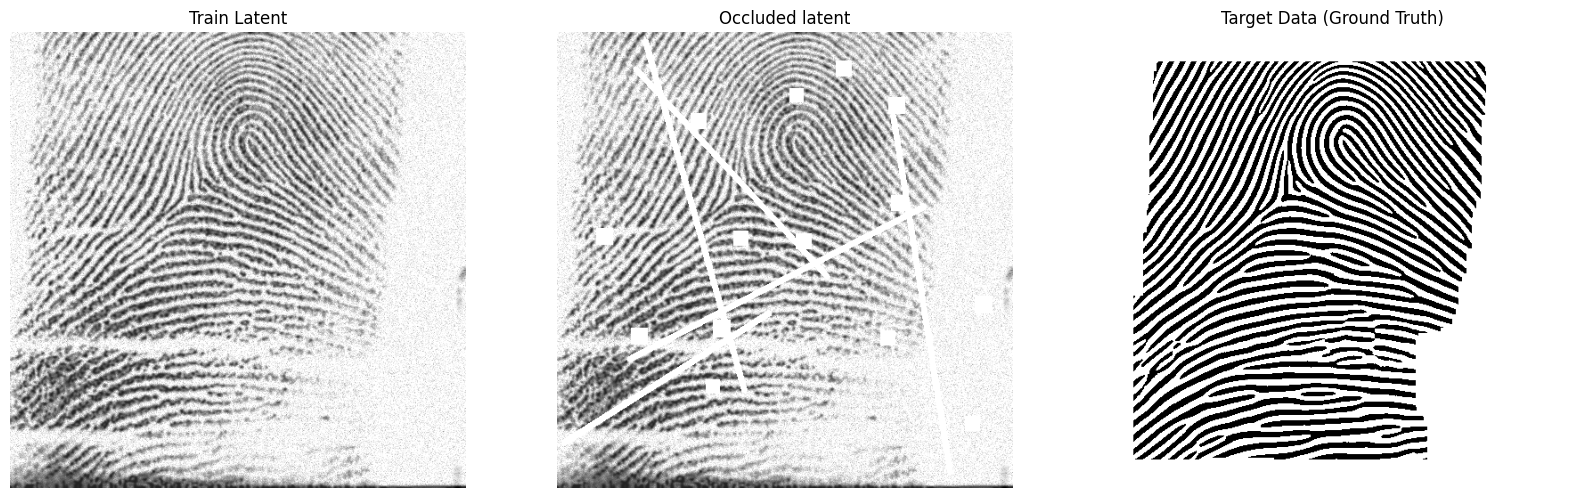

In [34]:
input = x[0][0]

input_occluded = np.where(occ_mask[0] == 0, input.max(), input)

gt_label = np.where(mask[0] == 0, bin[0].max(), bin[0])

fig, ax = plt.subplots(figsize = (20,15), nrows=1, ncols = 3)
ax[0].imshow(input, cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Train Latent')

ax[1].imshow(input_occluded, cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Occluded latent')

ax[2].imshow(gt_label, cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('Target Data (Ground Truth)')

/storage/seabra/miniconda3/envs/hydra/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


torch.Size([2, 1, 512, 512])


Text(0.5, 1.0, 'Occlusion Mask')

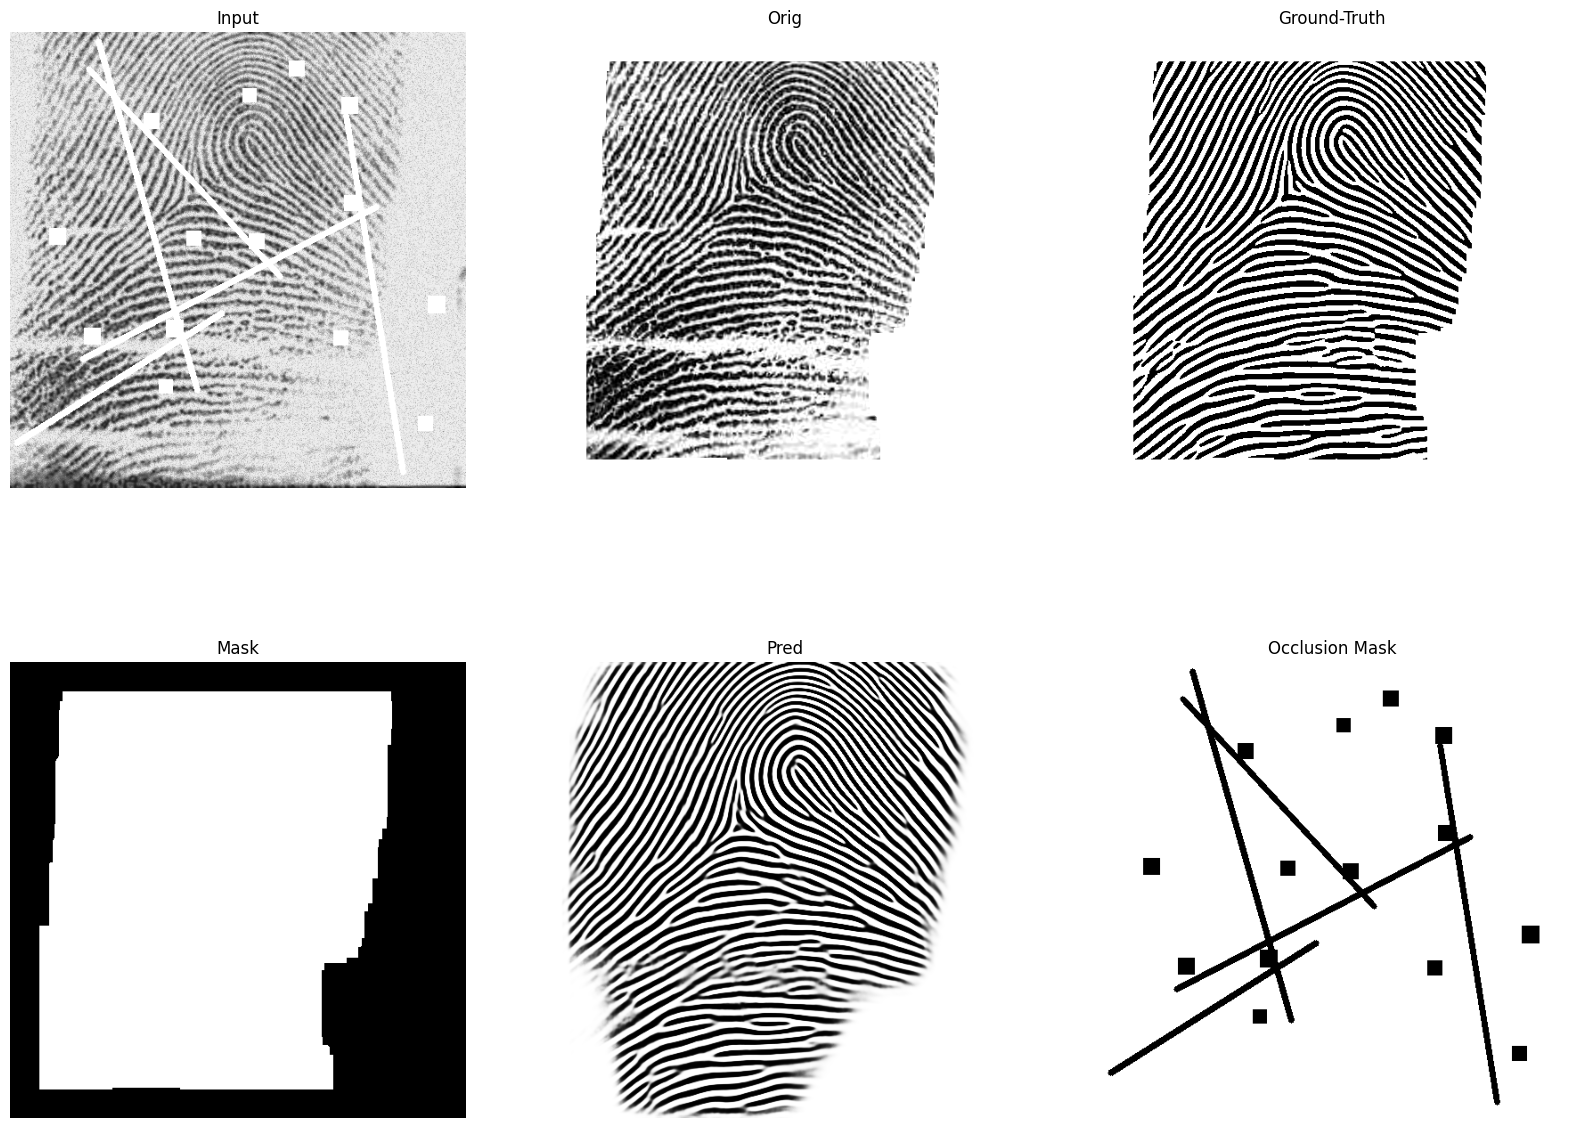

In [69]:
from data.enhancer_predict_datamodule import *

model_path = '/home/seabra/epoch_043.ckpt'
model      = EnhancerLitModule.load_from_checkpoint(model_path)

device = 'cpu'

model = model.to(device)



x[:,0,:,:] = torch.where(occ_mask == 0, torch.max(x[:,0,:,:]), x[:,0,:,:])

x     = x.to(device)

print(x.shape)

with torch.no_grad():
    model.eval()
    # enh, mask, mnts, orifield = model.forward(x)
    enh = model.forward(x)

fig, ax = plt.subplots(figsize = (20,15), nrows=2, ncols = 3)
ax[0][0].imshow(x[0][0], cmap = 'gray')
ax[0][0].axis('off')
ax[0][0].set_title('Input')

ax[0][1].imshow(orig[0], cmap = 'gray')
ax[0][1].axis('off')
ax[0][1].set_title('Orig')

ax[0][2].imshow(bin[0], cmap = 'gray')
ax[0][2].axis('off')
ax[0][2].set_title('Ground-Truth')

ax[1][0].imshow(mask[0], cmap = 'gray')
ax[1][0].axis('off')
ax[1][0].set_title('Mask')

bin_pred = torch.sigmoid(enh[0][1])

ax[1][1].imshow(bin_pred, cmap = 'gray')
ax[1][1].axis('off')
ax[1][1].set_title('Pred')

ax[1][2].imshow(occ_mask[0], cmap = 'gray')
ax[1][2].axis('off')
ax[1][2].set_title('Occlusion Mask')


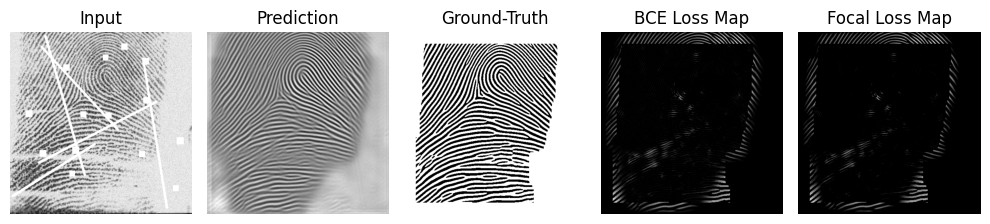

In [53]:
class MaskedBCELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets, mask):
        """
        :param logits: Tensor of shape (N, 1, H, W) - raw model outputs
        :param targets: Tensor of shape (N, 1, H, W) - binary labels
        :param mask: Tensor of shape (N, 1, H, W) - binary mask (1=foreground, 0=background)
        """
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')

        foreground = mask.bool()

        # Avoid empty masks by clamping denominator
        foreground_loss = bce_loss[foreground].mean() if foreground.any() else torch.tensor(0.0, device=logits.device)

        return foreground_loss.mean()

def focal_loss_with_logits(logits, targets, gamma=2.0, alpha=0.5):
    """
    logits: tensor de logits (antes da sigmoide)
    targets: tensor de rótulos binários (0 ou 1)
    """
    bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    probas = torch.sigmoid(logits)
    p_t = probas * targets + (1 - probas) * (1 - targets)
    # alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
    alpha_t = 1
    focal_term = (1 - p_t) ** gamma
    loss = alpha_t * focal_term * bce_loss
    return loss

loss_map           = F.binary_cross_entropy_with_logits(enh[:,1,:,:], bin, reduction='none')

focal_loss_map           = focal_loss_with_logits(enh[:,1,:,:], bin, gamma=5, alpha=1)


# minutia_weight_map =  extract_mcc_cpu(mnts_label, img.shape, 12, 5.0)
# minutia_weight_map.shape
# minutia_weight_map = (minutia_weight_map - torch.min(minutia_weight_map)) / (torch.max(minutia_weight_map) - torch.min(minutia_weight_map))

# criterion = MaskedWeightedBCELoss(foreground_weight=0.0)
# loss = criterion(enh[:,0,:,:], bin, mask)

# print(loss)

fig, ax = plt.subplots(figsize = (10,4), nrows = 1, ncols = 5)

ax[0].imshow(x[0][0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title("Input")

ax[1].imshow(enh[0,1,:,:], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title("Prediction")

ax[2].imshow(bin[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title("Ground-Truth")

ax[3].imshow(loss_map[0], cmap = 'gray')
ax[3].axis('off')
ax[3].set_title("BCE Loss Map")

ax[4].imshow(focal_loss_map[0], cmap = 'gray')
ax[4].axis('off')
ax[4].set_title("Focal Loss Map")

fig.tight_layout()
plt.show()

## Foreground Loss

Foreground Loss =  tensor(0.2290)


Text(0.5, 1.0, 'Foreground Loss Map')

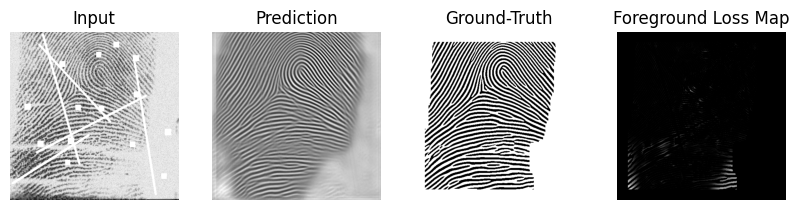

In [60]:
criterion = MaskedBCELoss()
loss = criterion(enh[:,1,:,:], bin, mask*occ_mask)
loss_map           = F.binary_cross_entropy_with_logits(enh[:,1,:,:], bin, reduction='none')
print("Foreground Loss = ", loss)

fig, ax = plt.subplots(figsize = (10,4), nrows = 1, ncols = 4)

ax[0].imshow(x[0][0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title("Input")

ax[1].imshow(enh[0,1,:,:], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title("Prediction")

ax[2].imshow(bin[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title("Ground-Truth")

ax[3].imshow(loss_map[0]*mask[0]*occ_mask[0], cmap = 'gray')
ax[3].axis('off')
ax[3].set_title("Foreground Loss Map")

## Background Loss

Background Loss =  tensor(0.6509)


Text(0.5, 1.0, 'Background Loss Map')

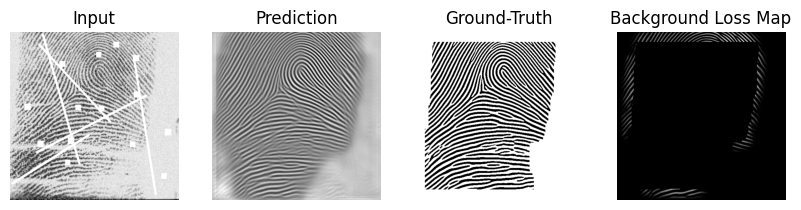

In [64]:
criterion = MaskedBCELoss()

back_mask = 1 - mask
loss = criterion(enh[:,1,:,:], bin, back_mask)
loss_map           = F.binary_cross_entropy_with_logits(enh[:,1,:,:], bin, reduction='none')
print("Background Loss = ", loss)

fig, ax = plt.subplots(figsize = (10,4), nrows = 1, ncols = 4)

ax[0].imshow(x[0][0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title("Input")

ax[1].imshow(enh[0,1,:,:], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title("Prediction")

ax[2].imshow(bin[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title("Ground-Truth")

ax[3].imshow(loss_map[0]*back_mask[0], cmap = 'gray')
ax[3].axis('off')
ax[3].set_title("Background Loss Map")

## Occlusion Loss

Background Loss =  tensor(0.5834)


Text(0.5, 1.0, 'Occlusion Loss Map')

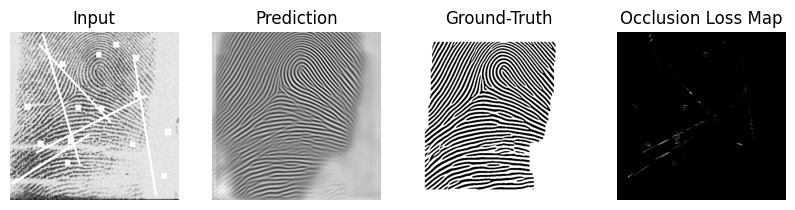

In [65]:
criterion = MaskedBCELoss()

occ_mask_inv = 1 - occ_mask
loss = criterion(enh[:,1,:,:], bin, occ_mask_inv)
loss_map           = F.binary_cross_entropy_with_logits(enh[:,1,:,:], bin, reduction='none')
print("Background Loss = ", loss)

fig, ax = plt.subplots(figsize = (10,4), nrows = 1, ncols = 4)

ax[0].imshow(x[0][0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title("Input")

ax[1].imshow(enh[0,1,:,:], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title("Prediction")

ax[2].imshow(bin[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title("Ground-Truth")

ax[3].imshow(loss_map[0]*occ_mask_inv[0], cmap = 'gray')
ax[3].axis('off')
ax[3].set_title("Occlusion Loss Map")

In [ ]:
enh.shape

torch.Size([2, 1, 512, 512])

In [ ]:
mnt_map.shape

torch.Size([2, 512, 512])